In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from numpy.random import seed
seed(20)  ##15 for left canal
import google.protobuf
import gast
import tensorflow as tf
tf.random.set_seed(20) ##32 for training 1
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

/home/rabeea/anaconda3/envs/beea/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14251970589967344868
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40075591680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 360647790053435514
physical_device_desc: "device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-05-15 08:20:32.145219: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 08:20:33.074964: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0
2023-05-15 08:20:33.084594: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


True

In [2]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import cv2
import skimage.transform as trans
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def dice_coef(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [4]:
paths = glob.glob("/home/rabeea/bul/**/*.png", recursive = True)
imgpath = []
for path in paths:
    if not 'mask' in path:
        imgpath.append(path)
print(len(imgpath))
tr = 400
val = 100
ts = 147
imgpath = sorted(imgpath)
random.Random(42).shuffle(imgpath)
trainpath = imgpath[:tr]
valpath = imgpath[tr:tr+val]
testpath = imgpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))
imgpath[0][:-4] + '_mask.png'

647
647 400 100 147


'/home/rabeea/bul/benign/benign (218)_mask.png'

In [5]:
from tensorflow.keras.utils import Sequence


def parse_image(img_path, image_size):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img ,image_size, interpolation = cv2.INTER_CUBIC)
    mn = np.amin(img)
    mx = np.amax(img)
    d = mx - mn
    img = (img-mn)/d
    img = np.expand_dims(img, axis=2)
    #train_img = np.stack((image_rgb,)*3, axis=-1)
    
    return img

def parse_mask(img_path, image_size):
    mask_path = img_path[:-4] + '_mask.png'
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask,image_size, interpolation = cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=2)
    mask = mask.astype(np.uint8)
    mask = np.where(mask>0,1,mask)
    return mask

class DataGen(Sequence):
    def __init__(self, image_size, images_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]

        #images_batch = np.empty((self.batch_size,image_size[0],image_size[1],image_size[2],3))
        images_batch = np.empty((self.batch_size,image_size[0],image_size[1],1))
        masks_batch = np.empty((self.batch_size,image_size[0],image_size[1],1),dtype = 'uint8')

        for i in range(len(images_path)):
            # Read image and mask
            images_batch[i]= parse_image(images_path[i], self.image_size)
            masks_batch[i] = parse_mask(images_path[i], self.image_size)

        #return np.array(images_batch), np.array(masks_batch)
        return images_batch,masks_batch

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))
    

In [6]:
image_size = (256,256)
batch_size = 8

epochs = 100

train_steps = len(trainpath)//batch_size
valid_steps = len(valpath)//batch_size

## Generator
train_gen = DataGen(image_size, trainpath,batch_size=batch_size)
valid_gen = DataGen(image_size,valpath, batch_size=batch_size)

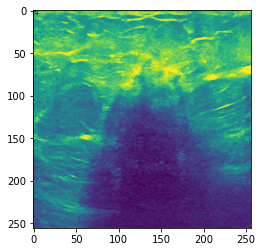

In [7]:
t = train_gen.__getitem__(0)[0]
p = train_gen.__getitem__(0)[1]
plt.imshow(t[1,:,:,0])

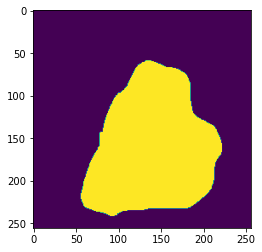

In [8]:
plt.imshow(p[1,:,:,0])

In [7]:
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [8]:
class attention_unet():
    def __init__(self,img_rows=256,img_cols=256):
        self.img_rows=img_rows
        self.img_cols=img_cols
        self.img_shape=(self.img_rows,self.img_cols,1)
        self.df=64
        self.uf=64
    
    def build_unet(self):
        def conv2d(layer_input,filters,dropout_rate=0,bn=False):
            d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
            if bn:
                d=layers.BatchNormalization()(d)
            d=layers.Activation('relu')(d)

            d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
            if bn:
                d=layers.BatchNormalization()(d)
            d=layers.Activation('relu')(d)

            if dropout_rate:
                d=layers.Dropout(dropout_rate)(d)

            return d
        def deconv2d(layer_input,filters,bn=False):
            u=layers.UpSampling2D((2,2))(layer_input)
            u=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(u)
            if bn:
                u=layers.BatchNormalization()(u)
            u=layers.Activation('relu')(u)

            return u
    
        def attention_block(F_g,F_l,F_int,bn=False):
            g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
            if bn:
                g=layers.BatchNormalization()(g)
            x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
            if bn:
                x=layers.BatchNormalization()(x)
            #    print(g.shape)
            #    print(x.shape)
            psi=layers.Add()([g,x])
            psi=layers.Activation('relu')(psi)
            psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)

            if bn:
                psi=layers.BatchNormalization()(psi)
            psi=layers.Activation('sigmoid')(psi)

            return layers.Multiply()([F_l,psi])
        
        inputs=layers.Input(shape=self.img_shape)
    
        conv1=conv2d(inputs,self.df)
        pool1=layers.MaxPooling2D((2,2))(conv1)

        conv2=conv2d(pool1,self.df*2,bn=True)
        pool2=layers.MaxPooling2D((2,2))(conv2)

        conv3=conv2d(pool2,self.df*4,bn=True)
        pool3=layers.MaxPooling2D((2,2))(conv3)

        conv4=conv2d(pool3,self.df*8,dropout_rate=0.5,bn=True)
        #pool4=layers.MaxPooling2D((2,2))(conv4)

        #conv5=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)

#         up6=deconv2d(conv5,self.uf*8,bn=True)
#         conv6=attention_block(up6,conv4,self.uf*8,bn=True)
#         up6=layers.Concatenate()([up6,conv6])
#         conv6=conv2d(up6,self.uf*8)
        
        up7=deconv2d(conv4,self.uf*4,bn=True)
        conv7=attention_block(up7,conv3,self.uf*4,bn=True)
        up7=layers.Concatenate()([up7,conv7])
        conv7=conv2d(up7,self.uf*4)
        
#         up7=deconv2d(conv6,self.uf*4,bn=True)
#         conv7=attention_block(up7,conv3,self.uf*4,bn=True)
#         up7=layers.Concatenate()([up7,conv7])
#         conv7=conv2d(up7,self.uf*4)

        up8=deconv2d(conv7,self.uf*2,bn=True)
        conv8=attention_block(up8,conv2,self.uf*2,bn=True)
        up8=layers.Concatenate()([up8,conv8])
        conv8=conv2d(up8,self.uf*2)
        
        up9=deconv2d(conv8,self.uf,bn=True)
        conv9=attention_block(up9,conv1,self.uf,bn=True)
        up9=layers.Concatenate()([up9,conv9])
        conv9=conv2d(up9,self.uf)

        outputs=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)

        model=Model(inputs=inputs,outputs=outputs)
        
        

        return model

In [3]:
b=2
def hi():
    if b==2:
        print(‘no’)
        print('no')
hi()

SyntaxError: invalid character '‘' (U+2018) (1052285043.py, line 4)

In [9]:
a=attention_unet()
unet=a.build_unet()
unet.summary()

2023-05-15 08:22:17.167199: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38219 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 64  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_10 (Conv2D)             (None, 64, 64, 256)  65792       ['activation_5[0][0]']           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 64, 64, 256)  1024       ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 64, 64, 256)  1024       ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 add (Add)                      (None, 64, 64, 256)  0           ['batch_normalization_7[0][0]',  
          

                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 12  147584      ['activation_16[0][0]']          
                                8)                                                                
                                                                                                  
 activation_17 (Activation)     (None, 128, 128, 12  0           ['conv2d_19[0][0]']              
                                8)                                                                
                                                                                                  
 up_sampling2d_2 (UpSampling2D)  (None, 256, 256, 12  0          ['activation_17[0][0]']          
                                8)                                                                
                                                                                                  
 conv2d_20

In [12]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = "/home/rabeea/logs/attention_unet/bul_0001_64.h5"
tensorboard = TensorBoard(log_dir='logs/attention_unet/bul_0001_64', histogram_freq=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', save_best_only=True, mode='max')
callbacks_list = [checkpoint,tensorboard]

In [13]:
unet.compile(loss=dice_loss,
             optimizer=Adam(0.0001),
             metrics=['accuracy',dice_coef])

In [14]:
history = unet.fit(train_gen,
                      validation_data=valid_gen,epochs=100,callbacks=callbacks_list)

Epoch 1/100
50/50 [==============================] - 25s 328ms/step - loss: 0.5379 - accuracy: 0.8511 - dice_coef: 0.4621 - val_loss: 0.7241 - val_accuracy: 0.9163 - val_dice_coef: 0.2766
Epoch 2/100
50/50 [==============================] - 14s 271ms/step - loss: 0.4193 - accuracy: 0.9102 - dice_coef: 0.5807 - val_loss: 0.8495 - val_accuracy: 0.8883 - val_dice_coef: 0.1505
Epoch 3/100
50/50 [==============================] - 13s 267ms/step - loss: 0.4052 - accuracy: 0.9126 - dice_coef: 0.5948 - val_loss: 0.8859 - val_accuracy: 0.8883 - val_dice_coef: 0.1141
Epoch 4/100
50/50 [==============================] - 13s 267ms/step - loss: 0.3953 - accuracy: 0.9153 - dice_coef: 0.6047 - val_loss: 0.9282 - val_accuracy: 0.8883 - val_dice_coef: 0.0718
Epoch 5/100
50/50 [==============================] - 13s 267ms/step - loss: 0.3532 - accuracy: 0.9249 - dice_coef: 0.6468 - val_loss: 0.9732 - val_accuracy: 0.8883 - val_dice_coef: 0.0268
Epoch 6/100
50/50 [==============================] - 13s 269

50/50 [==============================] - 14s 271ms/step - loss: 0.0179 - accuracy: 0.9953 - dice_coef: 0.9821 - val_loss: 0.3709 - val_accuracy: 0.9311 - val_dice_coef: 0.6291
Epoch 88/100
50/50 [==============================] - 14s 271ms/step - loss: 0.0167 - accuracy: 0.9956 - dice_coef: 0.9833 - val_loss: 0.3484 - val_accuracy: 0.9326 - val_dice_coef: 0.6516
Epoch 89/100
50/50 [==============================] - 14s 272ms/step - loss: 0.0159 - accuracy: 0.9958 - dice_coef: 0.9841 - val_loss: 0.3593 - val_accuracy: 0.9310 - val_dice_coef: 0.6407
Epoch 90/100
50/50 [==============================] - 14s 271ms/step - loss: 0.0149 - accuracy: 0.9961 - dice_coef: 0.9851 - val_loss: 0.3424 - val_accuracy: 0.9334 - val_dice_coef: 0.6576
Epoch 91/100
50/50 [==============================] - 14s 271ms/step - loss: 0.0144 - accuracy: 0.9962 - dice_coef: 0.9856 - val_loss: 0.3340 - val_accuracy: 0.9335 - val_dice_coef: 0.6660
Epoch 92/100
50/50 [==============================] - 14s 270ms/step

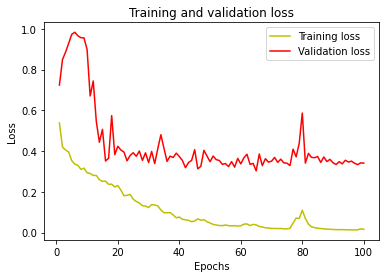

In [15]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

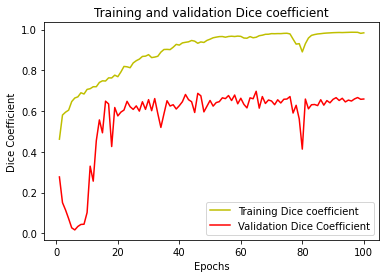

In [16]:
acc = history.history['dice_coef']
val_acc = history.history['val_dice_coef']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [18]:
unet.load_weights("logs/attention_unet/bul_0001_64.h5")

In [17]:
max(history.history['val_dice_coef'])

0.6973416805267334

In [21]:
test_gen = DataGen(image_size,testpath, batch_size=1)
tr_dice=[]
for k in tqdm(range(len(testpath))):
    try:
        y_pred=unet.predict(test_gen.__getitem__(k)[0])
        y_pred_argmax=np.where(y_pred>0.53,1,0)
        true_msk=test_gen.__getitem__(k)[1]
        if sum(sum(sum(sum(true_msk))))>0:
            
            tr_dice.append(compute_dice(y_pred_argmax, true_msk))
    except:
        print(k)
np.mean(tr_dice)

  0%|                                                                                          | 0/147 [00:00<?, ?it/s]C:\Users\Rabeea\AppData\Local\Temp\ipykernel_22244\257209271.py:58: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im1 = np.asarray(im1).astype(np.bool)
C:\Users\Rabeea\AppData\Local\Temp\ipykernel_22244\257209271.py:59: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/releas

0.5866694824905968